# Homework2 Neural Network Classification

Welcome to this assignment on implementing Neural Networks (NN) using PyTorch! In this notebook, we will be exploring the implementation of Multilayer Perceptron (MLP) and Convolutional Neural Network (CNN) for classification tasks. MLP and CNN are fundamental neural network architectures that have been extensively used in various fields such as computer vision, natural language processing, and many others. The primary objective of this assignment is to gain a practical understanding of implementing and training NNs using PyTorch, a popular open-source machine learning library. By the end of this assignment, you will have a good grasp of the essential concepts and practical aspects of MLP/CNN and PyTorch, which can be further applied to a variety of machine learning tasks. So, let's get started and dive into the world of NN and PyTorch!

## Environment
To running this code, you have to prepare a python environment. We recommend python version >= 3.8. You will need to install `torch`, `numpy` and `jupyter` packages. And in order to run the tests locally, you also need to install `matplotlib`.

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import math

## Basics

In this part, we will be focusing on the classification task using the PCAM(PatchCamelyon) dataset. PCAM containing images of 3x96x96 pixels (3 channels). The PCAM dataset is a widely-used histopathology image dataset that contains a large number of high-resolution images of lymph node sections. In this dataset, each image is labelled with a binary classification label indicating the presence or absence of metastatic tissue.

In this section, you will learn how to preprocess the dataset, implement and train an MLP model using PyTorch, and evaluate the model's performance on a validation set. By the end of this section, you will have a good understanding of how to implement and train an MLP model for a classification task, and be able to apply this knowledge to other classification problems in your future work. So, let's dive into the world of fashion and machine learning!

We will start by introducing the implementation of MLP without using the `torch.nn.module` class. This approach will help you to understand the basic mechanics of implementing an MLP from scratch and to gain a deeper understanding of the concepts involved. We will then move on to introduce the usage of the `torch.nn.module`, which provides a more convenient and efficient way to build neural networks using PyTorch. By the end of this section, you will have a clear understanding of both approaches to building an MLP in PyTorch, and be able to use these techniques to create more complex neural networks for a variety of machine learning tasks. So, let's dive in and start building our first MLP!

### Load Data
First, let's load the PCAM data. You will a subset of the original dataset to train and test locally (because the whole dataset is quite large) and evaluate your model on the test set in gradescope online.

In [2]:
# alternative way to download the dataset from the mirror if the next cell fails to download
import os
os.makedirs('data', exist_ok=True)
os.makedirs(os.path.join('data', 'pcam'), exist_ok=True)
!wget https://zenodo.org/record/2546921/files/camelyonpatch_level_2_split_valid_x.h5.gz?download=1 -O data/pcam/camelyonpatch_level_2_split_valid_x.h5.gz
!gzip -d data/pcam/camelyonpatch_level_2_split_valid_x.h5.gz
!wget https://zenodo.org/record/2546921/files/camelyonpatch_level_2_split_valid_y.h5.gz?download=1 -O data/pcam/camelyonpatch_level_2_split_valid_y.h5.gz
!gzip -d data/pcam/camelyonpatch_level_2_split_valid_y.h5.gz

--2024-03-07 03:20:34--  https://zenodo.org/record/2546921/files/camelyonpatch_level_2_split_valid_x.h5.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/2546921/files/camelyonpatch_level_2_split_valid_x.h5.gz [following]
--2024-03-07 03:20:35--  https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_valid_x.h5.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 805965320 (769M) [application/octet-stream]
Saving to: ‘data/pcam/camelyonpatch_level_2_split_valid_x.h5.gz’

data/pcam/camelyonp 100%[===================>] 768.63M  18.4MB/s    in 45s     

2024-03-07 03:21:20 (17.2 MB/s) - ‘data/pcam/camelyonpatch_level_2_split_valid_x.h5.gz’ saved [805965320/805965320]

--2024-03-07 03:21:30--  https://zenodo.org/record/2

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download data from open datasets. We only use a subset of the original dataset
use_dataset = datasets.PCAM(
    root="data",
    split='val',
    download=True,
    transform=transform
)

In [4]:
# This step may take some time to complete (Dozens of seconds to minutes, depending on your memory)
images_list = []
labels_list = []
data_point_n = len(use_dataset)
train_ratio = 5 / 6
train_num = int(data_point_n * train_ratio)

for i in range(train_num):
    images_list.append(use_dataset[i][0])
    labels_list.append(use_dataset[i][1])
x_train = torch.stack(images_list)
y_train = torch.tensor(labels_list)

images_list = []
labels_list = []
for i in range(train_num, data_point_n):
    images_list.append(use_dataset[i][0])
    labels_list.append(use_dataset[i][1])
x_valid = torch.stack(images_list)
y_valid = torch.tensor(labels_list)

# Delete the temporary variables to save some memory
del images_list
del labels_list

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)


torch.Size([27306, 3, 96, 96])
torch.Size([27306])
torch.Size([5462, 3, 96, 96])
torch.Size([5462])


Here we can show the image

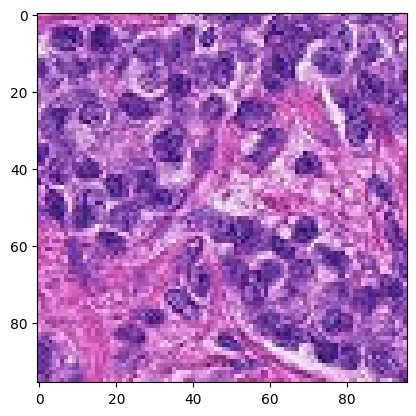

In [5]:
from matplotlib import pyplot
rgb_copy = x_train[0].clone()
permuted_image = rgb_copy.reshape(3, 96, 96).permute(1, 2, 0)
pyplot.imshow(permuted_image)

In [6]:
n, channels, h, w = x_train.shape
# print(x_train, y_train)
print(x_train.shape)

torch.Size([27306, 3, 96, 96])


### Build the model
PyTorch's built-in automatic gradient calculation feature allows us to use any regular Python function (or callable object) as a model. In this section, we will create a simple linear model by implementing plain matrix multiplication and broadcasted addition. We will also add an activation function using the log_softmax function. It is important to note that while PyTorch offers pre-built loss and activation functions, it is possible to create your own using standard Python code. PyTorch will automatically generate optimized GPU or vectorized CPU code for your custom function, resulting in faster processing times.

In [7]:
weights = torch.randn(3 * 96 * 96, 2) / math.sqrt(3 * 96 * 96)
weights.requires_grad_()
bias = torch.zeros(2, requires_grad=True)

In [8]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb.reshape(-1, 3*96*96) @ weights + bias)

In [9]:
batch_size = 64

xb = x_train[0: batch_size]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-1.4189, -0.2770], grad_fn=<SelectBackward0>) torch.Size([64, 2])


In [10]:
def nega_log_likehood(input, target):
    return -input[range(target.shape[0]), target].mean()

# Use negative log-likehood as the loss function
loss_func = nega_log_likehood

In [11]:
yb = y_train[0:batch_size]
print(loss_func(preds, yb))

tensor(0.6044, grad_fn=<NegBackward0>)


### Task 1: Implement accuracy function (5 points)
Accuracy is a commonly used metric for evaluating the performance of classification models. It is defined as the ratio of correctly classified samples to the total number of samples in the dataset. In this part of the assignment, we will be using accuracy as the evaluation metric for our MLP and CNN models on the PCAM dataset. The advantage of using accuracy is that it provides a simple and easy-to-understand measure of model performance. However, it does have some limitations, such as not accounting for class imbalance and not providing information about the types of errors made by the model. As the PCAM dataset is quite balanced, accuracy is an appropriate metric to use for this task. In this part of the assignment, you will be implementing a function to compute accuracy using PyTorch, which will allow you to evaluate the performance of your MLP and CNN models on the PCAM dataset.

Please calcualte the accuracy of the outputs.

$$
Accuracy = \frac{Number\ of\ correct\ predictions}{Total\ number\ of\ predictions}
$$

In [12]:
#export
import torch
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###
def accuracy(out, target):
    """
    out: tensor with shape (n, k), where k is the number of classes and n is the number of data points. This is the output of the model.
    target: tensor with shape (n)
    """
    # TODO: implement the accuracy function
    acc = 0.0
    preds = torch.argmax(out, dim=1)
    correct = torch.sum(preds == target).item()
    acc = correct / target.size(0)
    return acc

In [13]:
print(accuracy(preds, yb))

0.75


After calculating the gradients, we apply them to update the weights and bias of our model. To prevent these actions from being included in the next gradient calculation, we perform this step within the torch.no_grad() context manager. For further details about how PyTorch's Autograd records operations, please refer to the relevant documentation. Subsequently, we reset the gradients to zero, which is necessary to ensure that we begin each loop with a fresh set of gradients. Otherwise, the gradients would accumulate over the duration of our training and produce erroneous results. It is important to note that loss.backward() adds the gradients to the existing values rather than replacing them, which further underscores the necessity of resetting them to zero after each iteration.

In [14]:
lr = 0.001  # learning rate
epochs = 3 # number of epochs to train the model, you can change this parameter if you want

for epoch in range(epochs):
    for i in range((n - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

We have successfully developed and trained a basic neural network (in this instance, a logistic regression) entirely from the ground up! Since we have not included any hidden layers, this model is straightforward in its design. Our next step is to verify its performance by evaluating its loss and accuracy, and comparing them with our previous results. It is reasonable to assume that the loss would decrease while the accuracy would increase with each iteration, and our expectations have been met in this regard.

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0228, grad_fn=<NegBackward0>) 1.0


Our next course of action involves refactoring our existing code to take full advantage of PyTorch's nn classes, thereby enhancing its conciseness and flexibility without sacrificing functionality. Each subsequent step should aim to improve the code in one or more of the following ways: shorten it, enhance its clarity, or increase its flexibility. To begin with, we can employ the functions from torch.nn.functional to replace our hand-written activation and loss functions, making our code more compact. This module includes a wide range of activation and loss functions, as well as several functions for constructing neural networks, such as pooling functions. Although other parts of the library contain classes for implementing linear layers, convolutions, etc., we will explore these aspects further later on. Additionally, PyTorch provides a single function cross_entropy, which combines negative log likelihood loss and log softmax activation, thus enabling us to remove the activation function from our model.

In [16]:
loss_func = torch.nn.functional.cross_entropy

def model(xb):
    return xb.reshape(-1, 3*96*96) @ weights + bias

In [17]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0228, grad_fn=<NllLossBackward0>) 1.0


Our next step is to enhance the clarity and brevity of our training loop by using nn.Module and nn.Parameter. We can achieve this by creating a subclass of nn.Module, which is itself a class that is capable of maintaining state information. This class will hold the weights, bias, and forward method. nn.Module offers several useful methods and attributes (including .parameters() and .zero_grad()) that we can leverage in our implementation.

In [18]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(96 * 96 * 3, 2) / math.sqrt(96 * 96 * 3))
        self.bias = nn.Parameter(torch.zeros(2))

    def forward(self, xb):
        return xb.reshape(-1, 3*96*96) @ self.weights + self.bias

In [19]:
model = MLP()

In [20]:
print(loss_func(model(xb), yb))

tensor(1.8654, grad_fn=<NllLossBackward0>)


In the previous version of our training loop, we had to manually update the parameter values by their respective names, as well as zero out the gradients for each parameter individually. However, with the help of the built-in functions of PyTorch's nn.Module, namely model.parameters() and model.zero_grad(), we can significantly simplify these steps, reducing the likelihood of accidentally forgetting to update some parameters, especially in a more complex model. In addition, we'll encapsulate our training loop in a `train` function, enabling us to rerun it with ease in the future.

In [21]:
def train():
    for epoch in range(epochs):
        for i in range((n - 1) // batch_size + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

train()

In [22]:
print(loss_func(model(xb), yb))

tensor(0.0235, grad_fn=<NllLossBackward0>)


As we proceed to improve our code, we will replace the manual definition and initialization of self.weights and self.bias, as well as the calculation of xb @ self.weights + self.bias, with the PyTorch class nn.Linear, which already handles these processes for us. PyTorch provides various pre-defined layers that can significantly streamline our code, while also improving its speed.

In [23]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lin = nn.Linear(96 * 96 * 3, 2)

    def forward(self, xb):
        xb = self.flatten(xb)
        return self.lin(xb)

In [24]:
model = MLP()
print(loss_func(model(xb), yb))

tensor(0.7851, grad_fn=<NllLossBackward0>)


In [25]:
train()

print(loss_func(model(xb), yb))

tensor(0.0229, grad_fn=<NllLossBackward0>)


PyTorch provides a package called torch.optim, which includes a variety of optimization algorithms. We can utilize the step() method from our optimizer to take a forward step, rather than updating each parameter manually. By doing so, we can replace our previous optimization step, which was manually coded.

In [26]:
from torch import optim
def get_model():
    model = MLP()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.7963, grad_fn=<NllLossBackward0>)
tensor(0.0213, grad_fn=<NllLossBackward0>)


PyTorch provides an abstract class called Dataset, which can represent any data with a length and a way of indexing. This is done by implementing the len function, which is used by Python's built-in `__len__` function, and the `__getitem__` function, which allows indexing into the data. In this tutorial, we will create a custom FacialLandmarkDataset class that inherits from Dataset.

PyTorch also provides a TensorDataset class, which is a Dataset that wraps tensors. By defining a length and indexing method, it allows us to easily iterate, index, and slice along the first dimension of a tensor. This makes it simpler to access both the independent and dependent variables in a single line during training.

In [27]:
from torch.utils.data import TensorDataset

In [28]:
train_ds = TensorDataset(x_train, y_train)

In [29]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // batch_size + 1):
        xb, yb = train_ds[i * batch_size: i * batch_size + batch_size]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0228, grad_fn=<NllLossBackward0>)


The task of managing batches is handled by PyTorch's DataLoader. Given any Dataset, a DataLoader can be created. The DataLoader simplifies the iteration over batches. Instead of manually slicing the data into batches, the DataLoader automatically provides each mini-batch.

In [30]:
train_dl = DataLoader(train_ds, batch_size=batch_size)

In [31]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0221, grad_fn=<NllLossBackward0>)


In the previous section, we focused on setting up a functional training loop for our training data. However, it's important to have a validation set to ensure that we're not overfitting. Shuffling the training data is essential to prevent correlation between batches and overfitting. Conversely, shuffling the validation set is unnecessary because the validation loss will be the same whether or not the data is shuffled. Because the validation set doesn't require backpropagation, it takes up less memory than the training set, which allows us to use a larger batch size and compute the loss more quickly. For this reason, we'll use a batch size for the validation set that is twice as large as the training set's batch size.

In [32]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

In [33]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(1.2198)
1 tensor(1.8803)
2 tensor(1.2779)


Great! It's time for you to get hands-on experience with implementing a Multi-Layer Perceptron (MLP) model using PyTorch. You will be building a fully connected neural network with multiple hidden layers to classify a given dataset. The MLP model is a fundamental and widely used deep learning model, so this is a great opportunity for you to learn by doing.

In [34]:
# You can change this batch size
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(train_ds, batch_size=batch_size)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size * 2)

for X, y in valid_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([256, 3, 96, 96])
Shape of y: torch.Size([256]) torch.int64


### Task2: Design the MLP model (8 points)

In this section of the assignment, you will be designing an MLP model to perform classification on the PCAM dataset. The MLP model class has been provided to you with some blank parts that you need to complete in order to implement the model.

You need to get 60% accuracy in the test set to get full scores.

In [56]:
#export
from torch import nn
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###

# Define model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        # TODO: Please design your MLP layers
        self.fc1 = nn.Linear(3*96*96, 512)
        self.relu1 = nn.ReLU()

        # Define the second hidden layer
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()

        # Define the output layer
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.flatten(x)
        # TODO: Finish this function
        # Apply layers in sequence
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

######################################################################
########## DON'T WRITE ANY CODE OUTSIDE THE CLASS! ###################
######## IF YOU WANT TO CALL OR TEST IT CREATE A NEW CELL ############
######################################################################

### Use CPU/GPU
PyTorch is a powerful deep learning library that supports GPU acceleration for faster training of neural networks. GPUs have been found to be particularly effective for deep learning tasks due to their ability to perform large-scale parallel computations. In this assignment, students have the option to use a GPU if it is available to them. If your computer has a compatible GPU and the necessary drivers installed, PyTorch will automatically detect and use it for training your models. Using a GPU can significantly speed up the training process, which can be particularly useful for larger datasets or more complex models. However, if you do not have access to a GPU, PyTorch will still be able to run on a CPU. Regardless of whether you choose to use a GPU or not, PyTorch provides a user-friendly and efficient platform for implementing and training neural networks for classification tasks.

In [57]:
# Get cpu or gpu device for training. mps for mac
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [58]:
# bind the model to the device
model = MLP().to(device)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=27648, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)


In [59]:
loss_fn = nn.CrossEntropyLoss()
# Try different learning rate
learning_rate = 0.001

# Try different optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [61]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [62]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(valid_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.703257  [    0/27306]
loss: 0.891801  [12800/27306]
loss: 0.710492  [25600/27306]
Valid Error: 
 Accuracy: 62.2%, Avg loss: 0.622530 

Epoch 2
-------------------------------
loss: 0.585126  [    0/27306]
loss: 0.684920  [12800/27306]
loss: 0.680378  [25600/27306]
Valid Error: 
 Accuracy: 63.0%, Avg loss: 0.602721 

Epoch 3
-------------------------------
loss: 0.565509  [    0/27306]
loss: 0.736262  [12800/27306]
loss: 0.672568  [25600/27306]
Valid Error: 
 Accuracy: 63.2%, Avg loss: 0.593139 

Epoch 4
-------------------------------
loss: 0.552287  [    0/27306]
loss: 0.737576  [12800/27306]
loss: 0.667546  [25600/27306]
Valid Error: 
 Accuracy: 63.9%, Avg loss: 0.586340 

Epoch 5
-------------------------------
loss: 0.546318  [    0/27306]
loss: 0.740185  [12800/27306]
loss: 0.675019  [25600/27306]
Valid Error: 
 Accuracy: 64.5%, Avg loss: 0.582709 

Epoch 6
-------------------------------
loss: 0.544002  [    0/27306]
loss: 0.753342 

### Save the model
You can save the model you have trained and load it when you need. When you have finished this assignment, you need to upload both this notebook and the models you trained to gradescope. And please note that gradescope has a size limit for the uploaded file of 100 MB. Do not define models with a large param size.

In [65]:
torch.save(model.state_dict(), "mlp.pth")
print("Saved PyTorch Model State to mlp.pth")

Saved PyTorch Model State to mlp.pth


In [64]:
model = MLP()
model.load_state_dict(torch.load("mlp.pth"))
model = model.to(device)
model.eval()
test(valid_dataloader, model, loss_fn)

Valid Error: 
 Accuracy: 66.3%, Avg loss: 0.564410 



In [66]:
from google.colab import files
files.download('mlp.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## CNN
In this section of the assignment, we will be using Convolutional Neural Networks (CNNs) to perform classification on the PCAM dataset. CNNs are a type of neural network that are specifically designed for image classification tasks. The main idea behind CNNs is to use convolutional layers to extract spatial features from the input image, followed by pooling layers to reduce the spatial dimensions of the features. The extracted features are then flattened and passed through one or more fully connected layers to perform the final classification.

### Task 3: Design the CNN model (12 points)
In this assignment, we have provided a CNN model class for you to use as a starting point. However, you will need to complete some blank parts of the class in order to implement the model. You will be using PyTorch to design and train your CNN model. During the training process, your model will learn to automatically extract relevant features from the input images, which can significantly improve classification accuracy compared to traditional machine learning algorithms. By the end of this section, you will have gained hands-on experience in designing a CNN model using PyTorch and trained it to classify images with high accuracy.

You can take a look at the "Deep Learning" slides if you do not know where to start.

You will get 8 points if get 68% accuracy and full scores for 72% accuracy.

In [67]:
#export
### DO NOT CHANGE ANY CODE ABOVE THIS LINE IN THIS CELL ###

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # TODO: Please design your CNN layers. They are typically made of some Conv2d layers and pool layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 24 * 24, 500)
        self.fc2 = nn.Linear(500, 2)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # TODO: Finish it
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 24 * 24)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

######################################################################
########## DON'T WRITE ANY CODE OUTSIDE THE CLASS! ###################
######## IF YOU WANT TO CALL OR TEST IT CREATE A NEW CELL ############
######################################################################

In [68]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [69]:
loss_fn = nn.CrossEntropyLoss()
# Try different learning rate
learning_rate = 0.001
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [70]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(valid_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.704031  [    0/27306]
loss: 0.565580  [12800/27306]
loss: 0.568493  [25600/27306]
Valid Error: 
 Accuracy: 70.6%, Avg loss: 0.565703 

Epoch 2
-------------------------------
loss: 0.598230  [    0/27306]
loss: 0.434315  [12800/27306]
loss: 0.611598  [25600/27306]
Valid Error: 
 Accuracy: 78.7%, Avg loss: 0.463866 

Epoch 3
-------------------------------
loss: 0.460705  [    0/27306]
loss: 0.397146  [12800/27306]
loss: 0.533098  [25600/27306]
Valid Error: 
 Accuracy: 79.0%, Avg loss: 0.429406 

Epoch 4
-------------------------------
loss: 0.443045  [    0/27306]
loss: 0.374684  [12800/27306]
loss: 0.487901  [25600/27306]
Valid Error: 
 Accuracy: 81.0%, Avg loss: 0.400161 

Epoch 5
-------------------------------
loss: 0.385994  [    0/27306]
loss: 0.355114  [12800/27306]
loss: 0.503627  [25600/27306]
Valid Error: 
 Accuracy: 83.8%, Avg loss: 0.362686 

Epoch 6
-------------------------------
loss: 0.350627  [    0/27306]
loss: 0.372092 

In [71]:
torch.save(model.state_dict(), "cnn.pth")
print("Saved PyTorch Model State to cnn.pth")

Saved PyTorch Model State to cnn.pth


In [72]:
model = CNN()
model.load_state_dict(torch.load("cnn.pth"))
model = model.to(device)
model.eval()
test(valid_dataloader, model, loss_fn)

Valid Error: 
 Accuracy: 86.3%, Avg loss: 0.327053 



In [73]:
from google.colab import files
files.download("cnn.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Submission

When you have tested your code locally, you can upload your notebook with the saved model files to gradescope to get evaluated.

Please submit a zip file to Gradescope that includes the following:

1. The `hw2_nn.ipynb` notebook file.
2. The `mlp.pth` MLP saved model file.
3. The `cnn.path` CNN saved model file.
4. The `weights.txt` file in Q1.
5. The `hw2_clf.ipynb` notebook file.

These saved models should have the same structure as the class of model in your notebook.

Please make sure that your code runs correctly and that you have included all necessary files in the zip file.
Please test your code before submitting to ensure that it runs correctly and all the outputs match the expected results.

**IMPORTANT**: Please **do not** include a root directory in the zip file. The three files should be compressed directly.